## 🟠 install the libraries.

In [ ]:
!pip install -q torchmetrics
!pip install -q portalocker>=2.0.0
!pip install wandb
!pip install librosa

#  **Import Libs**

In [3]:
import csv
import os
import sys
import time
import math
import random
import tqdm
from glob import glob
from typing import Any, Callable, Dict, List, Optional, Tuple
from IPython.display import Audio

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import librosa

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torch import optim

import torchvision
from torchvision import models

import torchaudio
import torchaudio.transforms as T

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torchmetrics as tm
from torchmetrics.aggregation import MeanMetric
from torchmetrics.text import WordErrorRate as WER

#  **Utils**

In [4]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [5]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

In [6]:
def time_for_each_batch(loader):
  start_time= time.time()
  for iter, (inputs, targets) in enumerate(loader, 1):
    continue

  end_time= time.time()
  total_time = end_time- start_time

  return total_time, total_time/ len(loader)


In [7]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

In [8]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

In [9]:
def plot_spectrogram(specgram, title=None, ylable="freq_bin", ax=None ):
  if ax is None:
    _, ax= plt.subplots(1,1)
  if title is not None:
    ax.set_title(title)

  ax.set_ylabel(ylable)
  ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


#  **Arguments**

In [10]:
seed = 8
wandb_enable = False
root = '/content/LJSpeech-1.1'
batch_size = 32
sample_rate = 22050
clip = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
lr = 0.1
momentum = 0.9
wd = 1e-4
num_epochs = 20

In [11]:
if wandb_enable:
  wandb_arg_name = input('Please input the WandB argument (run) name:')
  print(wandb_arg_name)

## 🟠 Change the font size of the output cells

In [12]:
print('Salam Howsam!')

Salam Howsam!


In [13]:
from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 14px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)

In [14]:
print('Salam Howsam!')

Salam Howsam!


#  **Dataset**

##  Load the Dataset

In [15]:
from google.colab import drive
drive.mount('/content/Drive')

Mounted at /content/Drive


In [16]:
dataset_path=''
!tar -xjf  dataset_path -C '/content'

##  Dataset preparation

###  Load CSV file


In [53]:
df = pd.read_csv(f'{root}/metadata.csv',
                 delimiter='|',names=['id','transcription','normalized_transcription'],
                 quoting= csv.QUOTE_NONE)

df.head(5)

,id,transcription,normalized_transcription
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


In [ ]:
item = random.randint(0, df.shape[0])
wave_id, txt, norm_txt = df.iloc[item]
print(wave_id, txt, norm_txt, sep='\n', end='\n\n')

waveform, sample_rate = torchaudio.load(f'{root}/wavs/{wave_id}.wav')
waveform, waveform.shape,waveform.dtype, sample_rate

In [ ]:
from IPython.display import  Audio
Audio(waveform, rate=sample_rate)

In [18]:
df.describe()

'|'

###  Find NaN values


In [ ]:
df[df.normalized_transcription.isna()]

###  Find duplicate rows


In [ ]:
duplicates = df[df.transcription.duplicated(keep=False)]
duplicates

,id,transcription,normalized_transcription
6551,LJ023-0098,And two other justices agreed with him.,And two other justices agreed with him.
6557,LJ023-0104,And two other justices agreed with him.,And two other justices agreed with him.
7777,LJ029-0001,Report of the President's Commission on the As...,Report of the President's Commission on the As...
7990,LJ030-0001,Report of the President's Commission on the As...,Report of the President's Commission on the As...
8039,LJ030-0050,The Presidential limousine.,The Presidential limousine.
8245,LJ031-0001,Report of the President's Commission on the As...,Report of the President's Commission on the As...
8478,LJ032-0001,Report of the President's Commission on the As...,Report of the President's Commission on the As...
8716,LJ032-0239,"on April 10, 1963.","on April ten, nineteen sixty-three."
8753,LJ033-0001,Report of the President's Commission on the As...,Report of the President's Commission on the As...
8764,LJ033-0012,The Curtain Rod Story,The Curtain Rod Story


###  Add path audio files to the dataframe


In [19]:
df['path'] = df['id'].apply(lambda x: f'{root}/wavs/{x}.wav')
df = df[['id','path','transcription','normalized_transcription']]
df.head()

,id,path,transcription,normalized_transcription
0,LJ001-0001,/content/LJSpeech-1.1/wavs/LJ001-0001.wav,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,/content/LJSpeech-1.1/wavs/LJ001-0002.wav,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,/content/LJSpeech-1.1/wavs/LJ001-0003.wav,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,/content/LJSpeech-1.1/wavs/LJ001-0004.wav,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,/content/LJSpeech-1.1/wavs/LJ001-0005.wav,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


###  Create train, validation, and test subsets from the dataset


In [20]:
generator= torch.Generator().manual_seed(seed)
train, valid, test = random_split(df, lengths=[0.75, 0.10, 0.15], generator=generator)

In [ ]:
len(train.indices), len(valid.indices), len(test.indices)

(9825, 1310, 1965)

#### ⚪ Train

In [21]:
df_train = df.iloc[train.indices]
print(df_train.shape)
df_train.to_csv(f'{root}/train-subset.csv', index=False)

(9825, 4)


#### ⚪ Validation

In [22]:
df_valid = df.iloc[valid.indices]
print(df_valid.shape)
df_valid.to_csv(f'{root}/valid-subset.csv', index=False)

(1310, 4)


#### ⚪ Test

In [23]:
df_test = df.iloc[test.indices]
print(df_test.shape)
df_test.to_csv(f'{root}/test-subset.csv', index=False)

(1965, 4)


### 🟡 Build a vocab


In [24]:
from torchtext.vocab import build_vocab_from_iterator

df_train= pd.read_csv(f'{root}/train-subset.csv')

In [25]:
vocabs = build_vocab_from_iterator(df_train.normalized_transcription.apply(lambda x: x.lower()),
                                   min_freq=10, specials=['=','#','<','>'], special_first=True)

vocabs.set_default_index(1)
print(vocabs.get_itos())

['=', '#', '<', '>', ' ', 'e', 't', 'a', 'o', 'n', 'i', 's', 'r', 'h', 'd', 'l', 'c', 'f', 'u', 'm', 'w', 'p', 'g', 'y', 'b', ',', 'v', '.', 'k', 'x', '-', 'q', "'", 'j', '"', ';', 'z', ':', '(', ')', '?', '!']


In [26]:
torch.save(vocabs, f'{root}/vocabs.pt')

## 🟠 EDA

### 🟡 Identify characteristics of audio files within the dataset


In [ ]:
item = random.randint(0, len(df_train))

wave, sample_rate= torchaudio.load(df_train.iloc[item]['path'])


sample_rate
Audio(wave,rate=sample_rate)

In [ ]:
df_train.iloc[item]['path']

'/content/Data/LJSpeech-1.1/wavs/LJ015-0268.wav'

### 🟡 Plot the audio files


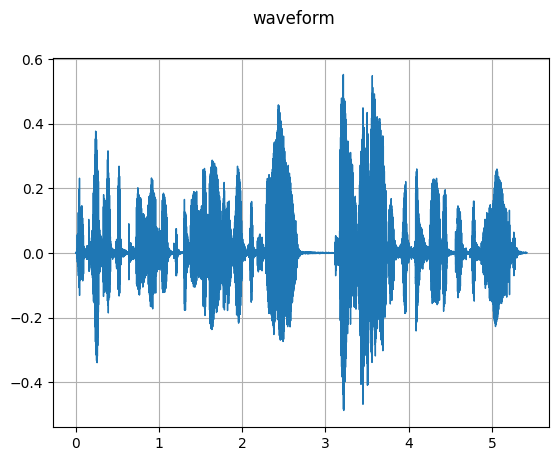

In [ ]:
plot_waveform(wave, sample_rate)

### 🟡 Plot the spectrogram of audio files


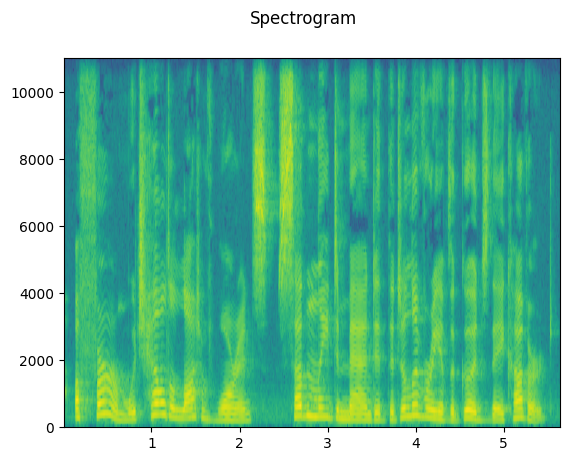

In [ ]:
item = random.randint(0, len(df_train))

wave, sample_rate= torchaudio.load(df_train.iloc[item]['path'])
plot_specgram(wave, sample_rate)

In [ ]:
spec_transform = T.MelSpectrogram(sample_rate=sample_rate, n_mels=150)
transformed_wave= spec_transform(wave)
transformed_wave.shape

torch.Size([1, 150, 622])

In [ ]:
start= time.time()

for i in range(len(df_train)):
  waveform, sample_rate= torchaudio.load(df_train.iloc[i]['path'])

end= time.time()

total= end-start
total/1e-6

## 🟠 Custom dataset

In [27]:
class LJSpeechDataset(Dataset):

  def __init__(self, root:str, csv_file:str, transform: Optional[Callable]=None,
               target_transform: Optional[callable]= None, memory: Optional[bool]= False):
    self.data = pd.read_csv(os.path.join(root,csv_file))
    self.phase = csv_file.split('-')[0].capitalize()

    self.transform = transform
    self.target_transform = target_transform
    self.memory = memory

    self.sos = target_transform(['<'])
    self.eos = target_transform(['>'])

    if memory:
      self._save_memory()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    if self.memory:
      waveform = self.audios[idx].clone().squeeze()
    else:
      waveform = torchaudio.load(self.data.iloc[idx]['path'])[0].squeeze()

    transcript = self.data.iloc[idx]['normalized_transcription']
    transcript = self.target_transform(list(transcript.lower()))
    transcript = self.sos + transcript + self.eos
    transcript = torch.LongTensor(transcript)

    return waveform, transcript


  def _save_memory(self):
    self.audios = []
    for path in self.data['path']:
      self.audios.append(torchaudio.load(path)[0])

  def __repr__(self):
    return f"Number of Datapoints: {len(self.data)}\nPhase: {self.phase}"


#### ⚪ Final

In [30]:
#vocabs = torch.load('vocab.pt')

train_set = LJSpeechDataset(root=root, csv_file='train-subset.csv', target_transform=vocabs, memory=False)

valid_set = LJSpeechDataset(root=root, csv_file='valid-subset.csv', target_transform=vocabs, memory=False)

test_set = LJSpeechDataset(root=root, csv_file='test-subset.csv', target_transform=vocabs, memory=False)

In [32]:
train_set[3]

(tensor([-0.0002, -0.0003, -0.0005,  ...,  0.0003,  0.0001,  0.0003]),
 tensor([ 2, 11, 13,  7,  9,  5, 23, 17,  5, 15,  6,  4, 16,  8, 19, 21,  7, 12,
          5, 14,  4,  6, 13, 10, 11,  4,  9,  5, 22,  7,  6, 10, 26,  5,  4, 20,
         10,  6, 13,  4,  7,  4,  9,  5, 22,  7,  6, 10, 26,  5,  4, 20, 13, 10,
         16, 13,  4, 13,  5,  4, 19,  7, 14,  5,  4, 24, 23,  4,  6,  7, 28, 10,
          9, 22,  4,  7,  4,  9,  5, 20,  4, 21, 10, 16,  6, 18, 12,  5,  4, 20,
         10,  6, 13,  4,  8, 11, 20,  7, 15, 14, 32, 11,  4, 16,  7, 19,  5, 12,
          7, 27,  3]))

## 🟠 Dataloader

In [33]:
def collate_fn(batch):
  x,y = zip(*batch)
  x = torch.nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=0).unsqueeze(1)
  y = torch.nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=0)
  return x,y

In [35]:
train_loader = DataLoader(train_set, batch_size= batch_size, shuffle=True, collate_fn=collate_fn)
valid_loader = DataLoader(valid_set, batch_size= batch_size, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size= batch_size, shuffle=False, collate_fn=collate_fn)

In [38]:
tr_gen = iter(train_loader)

In [56]:
waves, targets = next(tr_gen)
waves.shape, targets.shape

(torch.Size([32, 1, 217757]), torch.Size([32, 164]))

#### ⚪ Time per batch

In [ ]:
#time_for_each_batch(test_loader)

# 🔴 **Model**

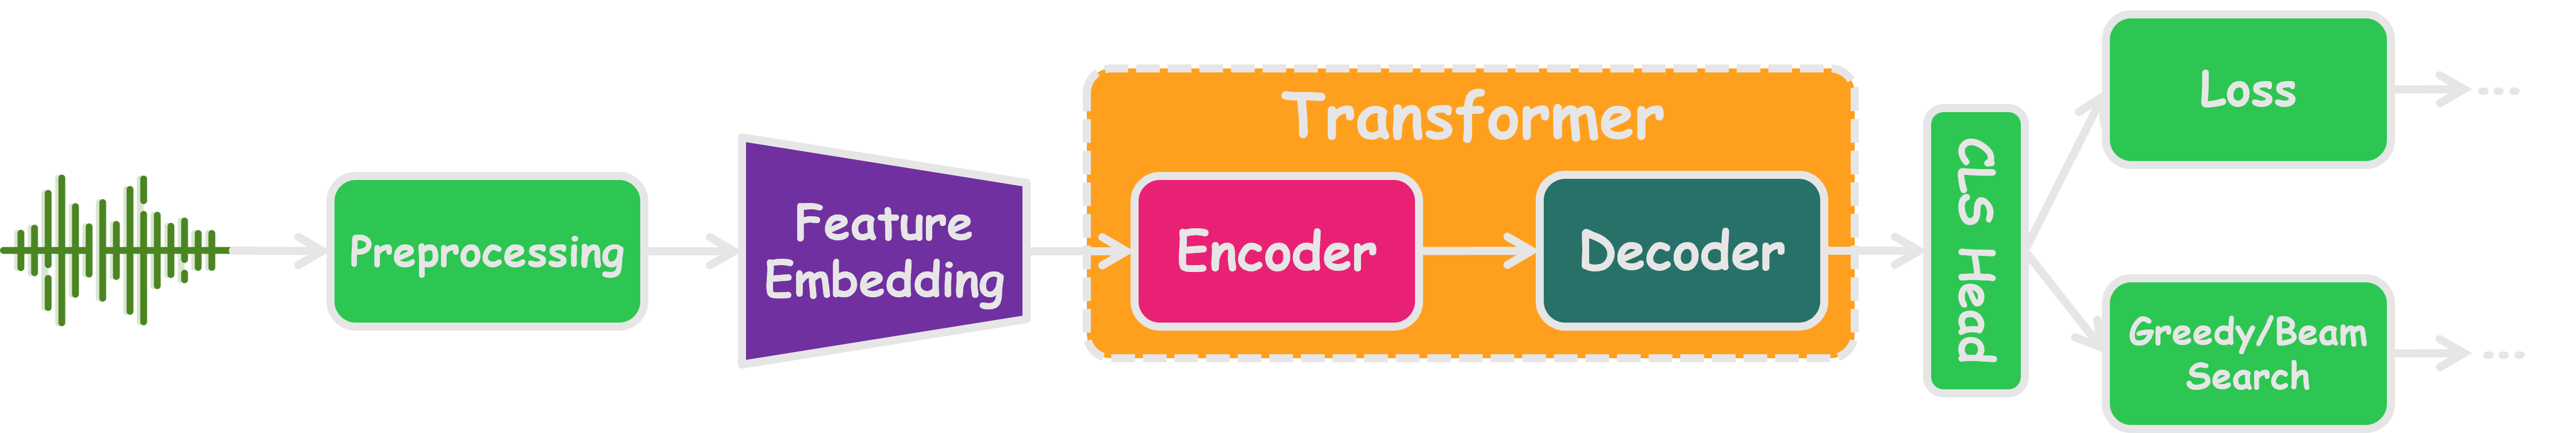

## 🟠 CNN Feature Embedding

### 🟡 Simple CNN Model

In [122]:
class CNN2dFeatureExtractor(nn.Module):
  def __init__(self, inplanes, planes):
    super().__init__()

    self.conv1 = nn.Conv2d(1, inplanes, kernel_size=11, stride=1, padding=5, bias=False)
    self.bn1   = nn.BatchNorm2d(inplanes)
    self.relu  = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.conv2 = nn.Conv2d(inplanes, planes, kernel_size=11, stride=1, padding=5, bias=False)
    self.bn2   = nn.BatchNorm2d(planes)

    self.conv3 = nn.Conv2d(planes, planes, kernel_size=11, stride=1, padding=5, bias=False)
    self.bn3   = nn.BatchNorm2d(planes)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=(2,1), padding=1)

  def forward(self, src):

    x = self.conv1(src)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    x = self.maxpool2(x)

    return x

In [101]:
model = CNN2dFeatureExtractor(inplanes=32, planes=64)
with torch.no_grad():
  out = model( torch.rand(2, 1, 80, 796))
out.shape

torch.Size([2, 64, 20, 398])

### 🟡 ResNet-based Model

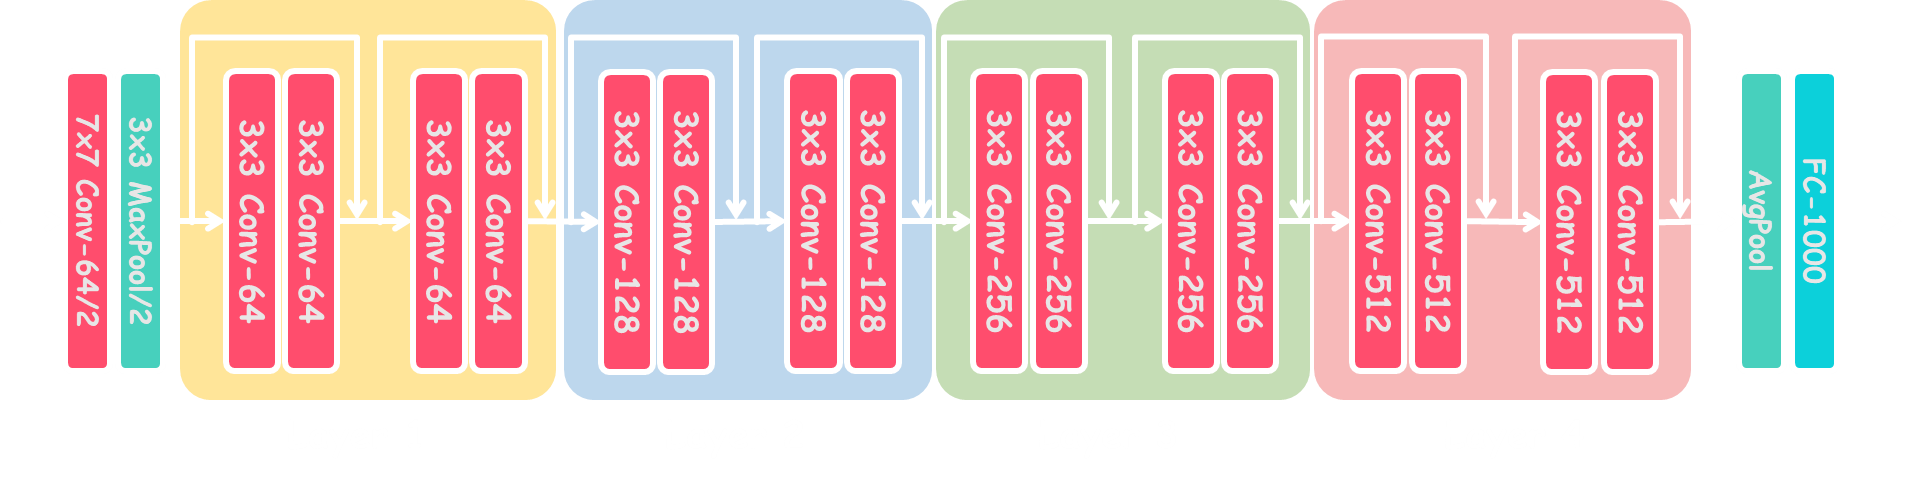

In [121]:
class ResNetFeatureExtractor(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = models.resnet18(models.ResNet18_Weights.IMAGENET1K_V1)
    model_list = list(self.model.children())
    self.model = nn.Sequential(*model_list[:-5])

  def forward(self, src):
    src= self.model(src)

    return src


In [113]:
model = ResNetFeatureExtractor().to(device)
with torch.no_grad():
  out = model(torch.randn((2, 3, 80, 796), device=device))
out.shape

torch.Size([2, 64, 20, 199])

## 🟠 Transformer

### 🟡 Positional Encoding

In [120]:
class PositionalEncoding(nn.Module):

  def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout)

    position = torch.arange(max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
    pe = torch.zeros(max_len, 1, d_model)
    pe[:, 0, 0::2] = torch.sin(position * div_term)
    pe[:, 0, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """
    Arguments:
        x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
    """
    x = x + self.pe[:x.size(0)]
    return self.dropout(x)

In [ ]:
pos_encoding = PositionalEncoding(d_model= 128, )
print(pos_encoding.pe.shape)
pos_encoding(torch.randn(200,2,128))


### 🟡 Transformer Model

In [119]:
class TransformerModel(nn.Module):
  def __init__(self, d_model, nhead, num_encoders, num_decoders, dim_feedforward,
               dropout= 0.1, activation = F.relu):
    super().__init__()

    self.d_model = d_model
    # Embedding
    self.embedding = nn.Embedding(len(vocabs), embedding_dim= d_model, padding_idx=0)
    # Position Encoding
    self.pos_encoder = PositionalEncoding(d_model=d_model)
    # Transformer
    self.transformer = nn.Transformer(d_model=d_model, nhead= nhead, num_encoder_layers= num_encoders,
                                      num_decoder_layers= num_decoders, dim_feedforward= dim_feedforward,
                                      activation = activation)
    self.init_weights()

  def init_weights(self) -> None:
      initrange = 0.1
      self.embedding.weight.data.uniform_(-initrange, initrange)


  def forward( self, src, target):
    target = self.embedding(target) * math.sqrt(self.d_model)
    target = target.permute(1,0,2)
    target = self.pos_encoder(target)

    target_mask = nn.Transformer.generate_square_subsequent_mask(len(target)).to(device)
    out = self.transformer(src, target, tgt_mask= target_mask)

    return out

In [ ]:
model = TransformerModel(d_model=128, nhead=4, num_encoders=4, num_decoders=1, dim_feedforward=128)
with torch.no_grad():
  out = model(src= torch.randn(50,32,128), target=targets)
out.shape

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


## 🟠 Speech Recognition Model

In [135]:
class SpeechRecognitionModel(nn.Module):

  def __init__(self,
               d_model, nhead, num_encoders, num_decoders, dim_feedforward, dropout=0.1, activation=F.relu,
               cnn_mode='simple', inplanes=32, planes=64,
               n_mels=128, n_fft=400):
    super().__init__()

    # Transform
    self.transforms = nn.Sequential(
        T.Resample(orig_freq=sample_rate, new_freq=16000),
        T.MelSpectrogram(n_mels=n_mels, n_fft=n_fft),
        # T.FrequencyMasking()
        ).requires_grad_(False)

    # Feature embedding
    self.cnn_mode = cnn_mode
    if cnn_mode == 'simple':
      self.cnn = CNN2dFeatureExtractor(inplanes=inplanes, planes=planes)
    elif cnn_mode == 'resnet':
      self.cnn = ResNetFeatureExtractor()
    else:
      raise NotImplementedError("Please select one of the simple or resnet model")

    # Transformer
    self.transformers = TransformerModel(
        d_model=d_model, nhead=nhead,
        num_encoders=num_encoders, num_decoders= num_decoders,
        dim_feedforward=dim_feedforward, dropout=dropout, activation=activation)

    # Classifier
    self.cls = nn.Linear(d_model, len(vocabs))

    self.init_weights()

  def init_weights(self) -> None:
    initrange = 0.1
    self.cls.bias.data.zero_()
    self.cls.weight.data.uniform_(-initrange, initrange)

  def forward(self, src, tgt):
    with torch.no_grad():
      src = self.transforms(src)

    if self.cnn_mode == 'resnet':
      src = src.repeat(1, 3, 1, 1)
    src = self.cnn(src)

    batch_size, num_channels, freq_bins, seq_len = src.shape
    src = src.reshape(batch_size, -1, seq_len)
    src = src.permute(2, 0, 1)

    out = self.transformers(src, tgt)
    out = out.permute(1, 0, 2)

    out = self.cls(out)

    return out

In [136]:
model= SpeechRecognitionModel(d_model=640, nhead=4, num_encoders=4, num_decoders=1,
                              dim_feedforward=640*2, cnn_mode= 'simple',
                              inplanes=32, planes=32 ,n_mels=80 )


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [137]:
with torch.no_grad():
  out = model(waves, targets)

out.shape

torch.Size([32, 164, 42])

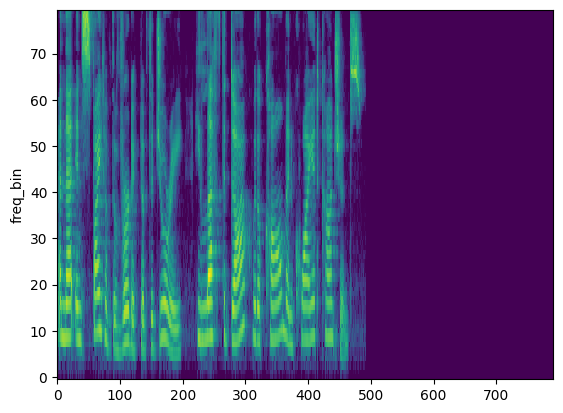

In [95]:
plot_spectrogram(out[0,0])

# 🔴 **Config**

In [149]:
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

metric = WER().to(device)

In [147]:
with torch.no_grad():
  output = model(waves, targets[:,:-1])

output.shape

loss_fn(output.permute(0,2,1), targets[:,1:])

torch.Size([32, 163, 42])

# 🔴 **Functions**

In [144]:
def postprocess(outputs, targets):
  generates, transcripts= [],[]
  for output, target in zip(outputs, targets):
    g = ''.join(vocabs.lookup_tokens(output.argmax(dim=-1).tolist()))
    generates.append(g)
    t = ''.join(vocabs.lookup_tokens(target.tolist()))
    transcripts.append(t)

  return generates, transcripts


In [156]:
generates, transcripts = postprocess(output, targets)
metric(generates, transcripts )

tensor(1.)

# 🔴 **Train ➰**

🔰 This is the template for train function, change it if needed.

In [154]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, scheduler=None, epoch=None):
  model.train()
  loss_train = MeanMetric()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs, targets[:, :-1])

      loss = loss_fn(outputs.permute(0, 2, 1), targets[:, 1:])

      loss.backward()
      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=clip)

      optimizer.step()
      optimizer.zero_grad()

      if scheduler:
        scheduler.step()

      loss_train.update(loss.item(), weight=len(targets))

      outputs, targets = postprocess(outputs, targets)
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.compute().item(),
                         metric=metric.compute().item())

  return model, loss_train.compute().item(), metric.compute().item()

# 🔴 **Evaluation**

🔰 This is the template for evaluation function, change it if needed.

In [155]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = MeanMetric()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs, targets[:, :-1])

      loss = loss_fn(outputs.permute(0, 2, 1), targets[:, 1:])
      loss_eval.update(loss.item(), weight=len(targets))

      outputs, targets = postprocess(outputs, targets)
      metric.update(outputs, targets)

  return loss_eval.compute().item(), metric.compute().item()

# 🔴 **Training Process 〽️**

## 🟠 Finding Hyper-parameters

### 🟡 **Step 1:** Calculate the loss for an untrained model using a few batches.


In [157]:
torch.cuda.empty_cache()

In [158]:
model = SpeechRecognitionModel(
    d_model=640, nhead=2, num_encoders=4, num_decoders=1, dim_feedforward=640,
    cnn_mode='simple', inplanes=32, planes=32,
    n_mels=80
    ).to(device)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs, targets)
  loss = loss_fn(outputs.permute(0, 2, 1), targets)

print(loss)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


tensor(4.3314)


### 🟡 **Step 2:** Try to train and overfit the model on a small subset of the dataset.

In [159]:
torch.cuda.empty_cache()

In [160]:
mini_train_size = 200
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20, shuffle=True, collate_fn=collate_fn)

In [161]:
model = SpeechRecognitionModel(
    d_model=640, nhead=2, num_encoders=4, num_decoders=1, dim_feedforward=640,
    cnn_mode='simple', inplanes=32, planes=32,
    n_mels=80
    ).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, None, epoch+1)

In [163]:
waveforms, targets = next(iter(mini_train_loader))
with torch.no_grad():
  outputs = model(waveforms.to(device), targets[:, :-1].to(device))
outputs, targets = postprocess(outputs, targets)

In [164]:
outputs[1], targets[1]

('hiiithedihneiehnniiini t neneiniin irniinneiii  t enhnr  iieneeteneeii hn eritenerthe idten hi  en  nesiit nerirhri  eni nnniiniei line>iiei ienrnsinninnln nnnii  ennint',
 '<all the tumultuous and diversified passions and emotions which circumstances like these must necessarily generate>=======================================================')

In [ ]:
torch.cuda.empty_cache()

### 🟡 **Step 3:** Train the model for a limited number of epochs, experimenting with various learning rates.

In [ ]:
num_epochs = 2

for lr in [1, 0.5, 0.1, 0.05, 0.01, 0.001, 0.0001]:
  print(f'LR={lr}')

  model = SpeechRecognitionModel(
    d_model=640, nhead=2, num_encoders=4, num_decoders=1, dim_feedforward=640,
    cnn_mode='simple', inplanes=32, planes=32,
    n_mels=80
    ).to(device)

  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, valid_loader, loss_fn, optimizer, metric, None, epoch+1)

  print()

LR=1


C:\Users\PC\anaconda3\envs\torchv2\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
Epoch 2: 100%|██████████████████████████████████████████████| 41/41 [00:16<00:00,  2.44batch/s, loss=45.3, metric=1.03]



LR=0.5


Epoch 2: 100%|██████████████████████████████████████████████| 41/41 [00:16<00:00,  2.44batch/s, loss=6.14, metric=1.15]



LR=0.1


Epoch 2: 100%|██████████████████████████████████████████████| 41/41 [00:16<00:00,  2.42batch/s, loss=2.56, metric=1.59]



LR=0.05


Epoch 2: 100%|███████████████████████████████████████████████| 41/41 [00:16<00:00,  2.44batch/s, loss=2.5, metric=1.96]



LR=0.01


Epoch 2: 100%|██████████████████████████████████████████████| 41/41 [00:17<00:00,  2.38batch/s, loss=2.56, metric=2.06]



LR=0.001


Epoch 2: 100%|██████████████████████████████████████████████| 41/41 [00:17<00:00,  2.40batch/s, loss=3.02, metric=1.84]



LR=0.0001


Epoch 2: 100%|██████████████████████████████████████████████| 41/41 [00:17<00:00,  2.40batch/s, loss=4.21, metric=1.12]

In [ ]:
torch.cuda.empty_cache()

### 🟡 Step 4: Create a small grid using the weight decay and the best learning rate.





In [ ]:
num_epochs =

for lr in [...]:
  for wd in [...]:
    print(f'LR={lr}, WD={wd}')

    model =
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

    for epoch in range(num_epochs):
      model, loss, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

    print()

### 🟡 Step 5: Train model for longer epochs using the best model from step 4.





In [ ]:
model =

In [ ]:
lr =
wd =
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs =

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                 train_set,
                                                 loss_fn,
                                                 optimizer,
                                                 metric,
                                                 epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_set,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

## 🟠 Main Loop

In [ ]:
torch.cuda.empty_cache()

🔰 Define model.

In [ ]:
set_seed(seed)
model = SpeechRecognitionModel(
    d_model=640, nhead=2, num_encoders=4, num_decoders=1, dim_feedforward=640,
    cnn_mode='simple', inplanes=32, planes=32,
    n_mels=80
    ).to(device)

C:\Users\PC\anaconda3\envs\torchv2\Lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
model = torch.load('model-0.57-0.68.pt')

In [ ]:
num_trainable_params(model), num_trainable_params(model.cnn), num_trainable_params(model.transformers)

(14.270474, 0.251872, 13.99168)

🔰 Define optimizer and Set learning rate and weight decay.

In [ ]:
set_seed(seed)
lr = 0.001
wd = 1e-4

optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9, nesterov=True)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

🔰 Initialize `wandb`

In [ ]:
if wandb_enable:
  wandb.init(
      project=...,
      name=wandb_arg_name,
      config={
          'lr': lr,
          'momentum': momentum,
          'batch_size': batch_size,
          'seq_len': seq_len,
          'hidden_dim': hidden_dim,
          'embedding_dim': embedding_dim,
          'num_layers': num_layers,
          'dropout_embed': dropoute,
          'dropout_in_lstm': dropouti,
          'dropout_h_lstm': dropouth,
          'dropout_out_lstm': dropouto,
          'clip': clip,
      }
  )

🔰 Write code to train the model for `num_epochs` epoches.

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [ ]:
num_epochs = 30

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    None,
                                                    epoch+1)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  if wandb_enable:
    wandb.log({"metric_train": metric_train, "loss_train": loss_train,
                "metric_valid": metric_valid, "loss_valid": loss_valid})

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

In [ ]:
wandb.finish()

## 🟠 Plot

🔰 Plot learning curves

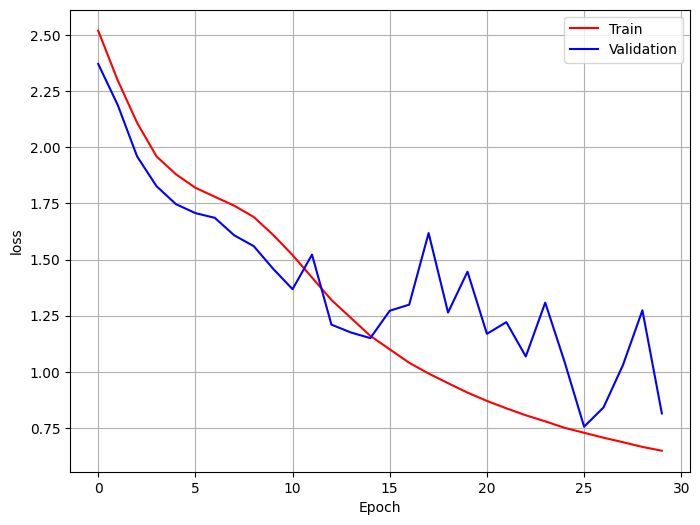

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

plt.plot(range(30), loss_train_hist, 'r-', label='Train')
plt.plot(range(30), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

## 🟠 Check the best model quality

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

In [ ]:
with torch.no_grad():
  inputs, targets = next(iter(valid_loader))
  inputs = inputs.to(device)
  targets = targets.to(device)
  outputs = model(inputs, targets[:, :-1])
  outputs, targets = postprocess(outputs, targets)

In [ ]:
item = random.randint(0, len(outputs))

print(outputs[item])
print(targets[item][1:])

metric.reset()
metric(outputs[item], targets[item])

on the afternoof of noverber twenty-three, officers ae eo morre,> eeeeeeeeeeeeeeee>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
on the afternoon of november twenty-three, officers h. m. moore,>=====================================================================================================


tensor(0.7000, device='cuda:0')

# 🔴 **Test**

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model_path = 'model.pt'
model = torch.load(model_path)
model.eval()

🔰 Test your model using data from the test set and images that are not present in the dataset.

In [ ]:
test_loader = DataLoader(test_set, batch_size=32, collate_fn=collate_fn)

In [ ]:
_, metric_test = evaluate(model, test_loader, loss_fn, metric)
metric_test

0.6738178133964539

In [ ]:
test_loader = DataLoader(test_set, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [ ]:
with torch.no_grad():
  inputs, targets = next(iter(test_loader))
  inputs = inputs.to(device)
  targets = targets.to(device)
  outputs = model(inputs, targets[:, :-1])
  outputs, targets = postprocess(outputs, targets)

print(outputs[0])
print(targets[0][1:])

metric.reset()
metric(outputs, targets)

in five fherty-eight the haty tell, and for a time tn became the home of the persinn teng, 
in five thirty-eight the city fell, and for a time it became the home of the persian king.>


tensor(0.3889, device='cuda:0')